___
# Understanding the Weather-Speed Nexus
**Exploring the Influence of Weather Conditions on Urban Speed Enforcement and Traffic Safety in Cologne**
___

### Project Objective:
- Analyze the `correlation` between two datasets: recorded incidents of urban speeding violations in Cologne from 2017 and Cologne Weather History
- Investigate whether there is a `relationship between` the weather conditions (`ground temperature`, `wind speed`, `precipitation`, `sunshine duration`, `air temperature`, and `relative humidity`) and the recorded speed violations
- Explore potential connections between weather factors and the frequency and severity of speed violations
- Gain insights into **how weather factors may influence driving behaviors and contribute to speed-related incidents**
- Contribute to a better understanding of the broader relationship between weather and traffic safety in Cologne

___
### Import Data and Rename columns for next steps of Analysis
___

#### Import the required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Loading Data

In [3]:
conn = sqlite3.connect('../data/data.sqlite')
speed_data = pd.read_sql_query("SELECT * FROM data_speed", conn)
weather_data = pd.read_sql_query("SELECT * FROM data_weather", conn)
conn.close()

In the provided code snippet, you are renaming the columns of a DataFrame called speed_data. The rename() function is used to change the names of columns in a DataFrame

In [4]:
speed_data.rename(columns={
    'jahr': 'year',
    'monat': 'month',
    'vorfallsdatum': 'incident_date',
    'vorfallsuhrzeit': 'incident_time',
    'Kennz': 'location_license_plate',
    'geschwindigkeit': 'speed',
    'ueberschreitung': 'exceeding',
    'fahrzeugart': 'vehicle_type',
    'dienststelle': 'office',
    'standort': 'incident_location'
}, inplace=True)

In [5]:
weather_data.rename(columns={
    'Unnamed: 0': 'date_time'}, inplace = True)

#### Chek for missing values:
- Check again after filtering the data

In [6]:
print("Missing values in speed_data:")
print(speed_data.isnull().sum())

print("\nMissing values in weather_data:")
print(weather_data.isnull().sum())

Missing values in speed_data:
year                           0
month                          0
incident_date                  0
incident_time                  0
location_license_plate     58612
speed                          0
exceeding                      1
vehicle_type                   0
office                    551096
incident_location              0
dtype: int64

Missing values in weather_data:
date_time                            0
GroundTempCelsius                11620
WindSpeedMeterPerSec               179
PrecipitationHeightMillimeter      223
SunshineMinutes                  48602
AirTempCelsius                       0
RelHumidityPercent                   4
dtype: int64


### For more understanding on the data please refer to `exploration.ipynb` file in the `project` folder of repo.

___
# Data Preperation
___

<!-- In the following code snippet, we are preparing the speed data for analysis by modifying the date and time columns. Firstly, we convert the 'incident_date' column to a datetime format and change the format to 'YYYY-MM-DD'. This allows us to have a consistent date representation. Secondly, we transform the 'incident_time' column by converting it to a string, removing any whitespace, padding the values with leading zeros to make them four digits, and then converting them to datetime-like format in the form 'HH:MM:SS'. This ensures that the time values are uniform and can be easily analyzed. Finally, we convert the modified 'incident_date' column back to datetime format to ensure consistency, and extract the time component from the 'incident_time' column, storing it as a time object. These preprocessing steps are crucial for conducting further analysis on the speed data and gaining insights from the temporal aspect of the incidents. -->


- Convert the `incident_date` column to a datetime format with the format `YYYY-MM-DD` of the speed data
- Convert the `incident_time` column to a datetime format with the format `HH:MM:SS` of the speed data
- These steps ensure consistent formatting and enable further analysis and insights based on the temporal aspect of the speed data

<!-- In the following code snippet, we are preparing the speed data for analysis by modifying the date and time columns. Firstly, we convert the 'incident_date' column to a datetime format and change the format to 'YYYY-MM-DD'. This allows us to have a consistent date representation. Secondly, we transform the 'incident_time' column by converting it to a string, removing any whitespace, padding the values with leading zeros to make them four digits, and then converting them to datetime-like format in the form 'HH:MM:SS'. This ensures that the time values are uniform and can be easily analyzed. Finally, we convert the modified 'incident_date' column back to datetime format to ensure consistency, and extract the time component from the 'incident_time' column, storing it as a time object. These preprocessing steps are crucial for conducting further analysis on the speed data and gaining insights from the temporal aspect of the incidents. -->

In [7]:
# Convert 'incident_date' to datetime and modify format
speed_data['incident_date_modified'] = pd.to_datetime(speed_data['incident_date'], format='%m%d%y', errors='coerce').dt.strftime('%Y-%m-%d')

# Convert 'incident_time' to datetime-like and modify format
speed_data['incident_time_modified'] = pd.to_datetime(speed_data['incident_time'].astype(str).str.strip().str.zfill(4), format='%H%M', errors='coerce').dt.strftime('%H:%M:%S')

speed_data['incident_date_modified'] = pd.to_datetime(speed_data['incident_date_modified'])
speed_data['incident_time_modified'] = pd.to_datetime(speed_data['incident_time_modified']).dt.time
speed_data

- Find the minimum and maximum dates in the "incident_date_modified" column of the speed data to determine the date range
- Find the minimum and maximum dates in the "date_time" column of the weather data to determine the date range of the weather dataset
- Filter both datasets to include only the data within the determined date range
- This  ensures that the analysis is performed on a consistent time period and aligns data to same duration, allowing for meaningful correlation and relationship understanding

In [8]:
min_date = speed_data['incident_date_modified'].min()
max_date = speed_data['incident_date_modified'].max()

print("Date Range: {} - {}".format(min_date, max_date))

Date Range: 2017-01-10 00:00:00 - 2022-12-12 00:00:00


In [9]:
min_date = weather_data['date_time'].min()
max_date = weather_data['date_time'].max()

print("Date Range: {} - {}".format(min_date, max_date))

Date Range: 2000-01-01 00:00:00 - 2021-12-31 23:00:00


In [10]:
start_date = pd.to_datetime('2017-01-10')
end_date = pd.to_datetime('2021-12-31')
speed_data_filtered = speed_data[(speed_data['incident_date_modified'] >= start_date) & (speed_data['incident_date_modified'] <= end_date)]

#### Shape of datasets before and after filtering

In [11]:
print('Speed_Data shape before filtering: ',speed_data.shape)
print('Speed_Data shape after filtering: ',speed_data_filtered.shape)

Speed_Data shape before filtering:  (3454540, 12)
Speed_Data shape after filtering:  (1153392, 12)


#### Repeat the same with weather data

In [12]:
weather_data['date_time'] = pd.to_datetime(weather_data['date_time'])
start_date = pd.to_datetime('2017-01-10')
end_date = pd.to_datetime('2021-12-31')
weather_data_filtered = weather_data[(weather_data['date_time'] >= start_date) & (weather_data['date_time'] <= end_date)]

#### Shape of datasets before and after filtering

In [13]:
print('weather_data shape before filtering: ',weather_data.shape)
print('weather_data shape after filtering: ',weather_data_filtered.shape)

weather_data shape before filtering:  (192864, 7)
weather_data shape after filtering:  (43585, 7)


In [14]:
print("Missing values in speed_data:")
print(speed_data_filtered.isnull().sum())

print("\nMissing values in weather_data:")
print(weather_data_filtered.isnull().sum())

Missing values in speed_data:
year                            0
month                           0
incident_date                   0
incident_time                   0
location_license_plate      16856
speed                           0
exceeding                       1
vehicle_type                    0
office                     218190
incident_location               0
incident_date_modified          0
incident_time_modified    1142729
dtype: int64

Missing values in weather_data:
date_time                            0
GroundTempCelsius                    0
WindSpeedMeterPerSec                 4
PrecipitationHeightMillimeter       28
SunshineMinutes                  10952
AirTempCelsius                       0
RelHumidityPercent                   0
dtype: int64


#### Missing Values Handling:
In the analysis, we focused on the count of violations from the speed data, which allowed us to derive meaningful insights. As for the weather data, we excluded the SunshineMinutes column due to missing values. However, it's worth noting that the remaining weather metrics have negligible missing values, which were handled during the scatterplot visualization and correlation calculation. By addressing the missing values appropriately, we ensured the integrity and accuracy of our analysis results

In [15]:
speed_data_filtered.head()

,year,month,incident_date,incident_time,location_license_plate,speed,exceeding,vehicle_type,office,incident_location,incident_date_modified,incident_time_modified
0,2017,1,10117,28,KL-,46,13,04a,None,40,2017-10-01,00:28:00
1,2017,1,10117,255,-87,49,16,04a,None,40,2017-10-01,02:55:00
2,2017,1,10117,437,K-,39,6,04a,None,40,2017-10-01,04:37:00
3,2017,1,10117,650,K-,42,9,04a,None,40,2017-10-01,06:50:00
4,2017,1,10117,933,SG-,73,10,04a,None,972,2017-10-01,09:33:00


In [16]:
weather_data_filtered.head()

,date_time,GroundTempCelsius,WindSpeedMeterPerSec,PrecipitationHeightMillimeter,SunshineMinutes,AirTempCelsius,RelHumidityPercent
149256,2017-01-10 00:00:00,1.8,3.7,0.6,NaN,2.5,94.0
149257,2017-01-10 01:00:00,1.8,4.3,1.1,NaN,2.4,95.0
149258,2017-01-10 02:00:00,1.9,4.0,2.2,NaN,2.4,97.0
149259,2017-01-10 03:00:00,1.9,4.2,2.7,0.0,2.1,97.0
149260,2017-01-10 04:00:00,1.8,4.6,2.3,0.0,1.3,96.0


___
# Data Analysis 
___

### Hour by Month - Speed Data

The provided code calculates the count of incidents reported for each hour of the day, grouped by month. The resulting DataFrame, speed_hourly_month, is a pivot table that represents the incident counts for each month and hour.

In [17]:
hourly_counts = speed_data_filtered.groupby(['month', speed_data_filtered['incident_time_modified'].apply(lambda x: x.hour)]).size().reset_index(name='count')
speed_hourly_month = hourly_counts.pivot(index='month', columns='incident_time_modified', values='count').fillna(0)
speed_hourly_month

incident_time_modified,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
month,,,,,,,,,,,,,,,,,,,,,,,,
1,37,33,25,20,33,25,29,26,29,29,45,29,24,19,34,23,21,20,25,23,25,23,28,25
2,22,44,36,39,33,41,27,30,45,44,32,42,37,26,31,42,35,32,32,39,36,30,33,36
3,43,28,44,32,43,30,48,34,46,40,44,40,43,51,47,35,31,37,40,48,41,47,41,39
4,32,28,35,33,32,22,30,22,17,28,19,22,31,45,23,27,28,24,31,19,26,22,25,26
5,25,20,28,21,12,22,25,22,12,26,12,14,11,23,23,17,19,21,22,19,18,16,18,16
6,32,28,29,36,32,32,25,39,28,38,33,37,28,27,31,40,32,40,33,25,34,28,32,37
7,53,30,40,42,41,35,45,53,45,40,41,36,40,46,31,48,45,43,42,46,39,44,36,43
8,39,37,36,38,39,44,43,52,43,32,52,53,34,52,32,37,43,42,38,58,38,42,46,47
9,33,37,54,45,39,48,59,42,44,47,38,44,47,32,45,50,43,46,38,44,46,41,37,43


1. **Monthly patterns:** There are variations in the number of incidents reported across different months. For example, in month 11 (November), there is a high number of incidents reported during hours 3, 6, 7, and 10, while in month 5 (May), the number of incidents remains relatively low throughout the day
2. **Peak hours:** Looking at the entire dataset, there seem to be specific hours during which a higher number of incidents occur consistently across the months. For instance, hour 11 (11:00 AM) appears to have a consistently high number of incidents across multiple months
3. **Hourly trends:** Some hours show recurring patterns of incidents across the months. For example, the number of incidents tends to be higher in the early morning hours (around hours 1 to 5) and in the evening hours (around hours 18 to 21)
4. **Month-to-month variations:** While there are recurring patterns, the number of incidents can still vary between months. For example, month 3 (March) and month 7 (July) have higher incident counts overall compared to other months

To further analyze and visualize these patterns, a `heatmap` can be generated using the data. The heatmap will provide a visual representation of the incident counts for each hour and month, allowing for easier identification of patterns and trends.

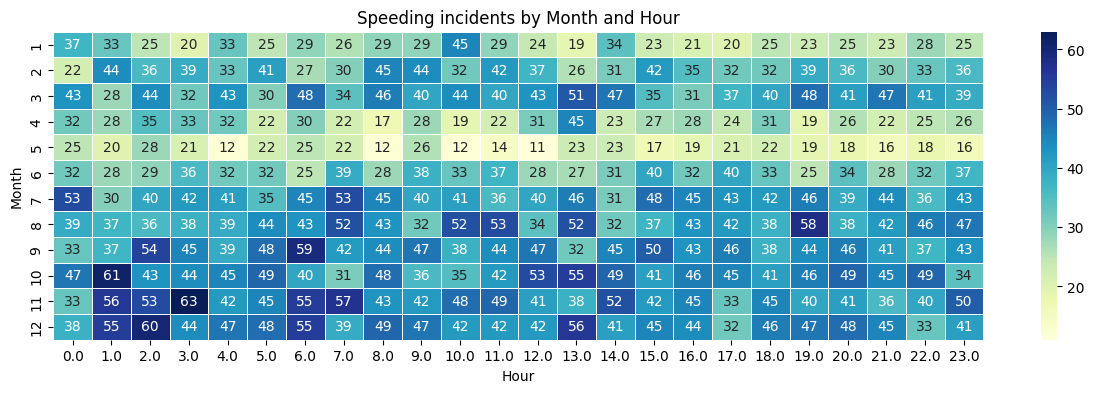

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap
plt.figure(figsize=(15, 4))
sns.heatmap(speed_hourly_month, cmap='YlGnBu', linewidths=0.5, annot=True, fmt="d")
plt.title('Speeding incidents by Month and Hour')
plt.xlabel('Hour')
plt.ylabel('Month')
plt.show()

### Hour by Month - Weather Data

In [19]:
weather_data_filtered_copy = weather_data_filtered.copy()
weather_data_filtered_copy.loc[:, 'year'] = weather_data_filtered_copy['date_time'].dt.year
weather_data_filtered_copy.loc[:, 'month'] = weather_data_filtered_copy['date_time'].dt.month

In [20]:
WindSpeedMeterPerSec_Avg = weather_data_filtered_copy.groupby(['month', weather_data_filtered_copy['date_time'].dt.hour])['WindSpeedMeterPerSec'].mean().reset_index()

### `WindSpeedMeterPerSec`

In [21]:
WindSpeedMeterPerSec_hourly_month = WindSpeedMeterPerSec_Avg.pivot(index='month', columns='date_time', values='WindSpeedMeterPerSec')
WindSpeedMeterPerSec_hourly_month

date_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
month,,,,,,,,,,,,,,,,,,,,,,,,
1,3.539726,3.528082,3.488356,3.527397,3.565068,3.563699,3.530822,3.488356,3.488356,3.550000,3.717808,3.950685,4.198630,4.293151,4.224658,4.097945,3.913014,3.747945,3.593151,3.562329,3.610959,3.606164,3.552740,3.586986
2,3.675177,3.630496,3.673759,3.587943,3.668085,3.639007,3.668085,3.670213,3.704965,3.911348,4.428369,4.784397,4.762411,4.869504,5.011348,4.895035,4.682979,4.258865,3.946099,3.826950,3.793617,3.690780,3.706383,3.736170
3,3.369032,3.331613,3.236774,3.205806,3.336129,3.386452,3.395484,3.485806,3.676774,4.109032,4.483226,4.787097,5.045806,5.194194,5.089032,5.152903,4.989032,4.743506,4.288312,3.887013,3.639610,3.505806,3.417419,3.219355
4,2.430000,2.334000,2.318000,2.316667,2.373333,2.371333,2.466667,2.628000,3.170000,3.445333,3.682000,3.998667,4.229333,4.287333,4.425333,4.436667,4.427333,4.349333,4.159333,3.497333,3.087333,2.852667,2.713333,2.716667
5,2.402581,2.406452,2.394194,2.304516,2.318065,2.334194,2.425161,2.643226,2.995484,3.349677,3.557419,3.841935,4.106452,4.134839,4.185161,4.236129,4.302581,4.280645,4.032258,3.545806,2.965161,2.751613,2.544516,2.403871
6,2.348667,2.243333,2.168667,2.258667,2.220667,2.126667,2.280000,2.667333,2.877333,3.188000,3.424000,3.752667,3.918000,4.020667,4.064000,4.054000,4.018000,4.049333,3.879333,3.554667,2.894667,2.599333,2.560000,2.600000
7,2.261935,2.203871,2.212258,2.204516,2.133548,2.134194,2.117419,2.374839,2.698710,2.942581,3.118065,3.396774,3.658065,3.703226,3.830968,3.941935,3.848387,3.845806,3.638710,3.430968,2.925806,2.524516,2.367742,2.237419
8,2.266452,2.241935,2.329677,2.303871,2.350968,2.312903,2.263226,2.352258,2.701290,2.920000,3.189677,3.443871,3.582581,3.725806,3.743226,3.771613,3.630968,3.627742,3.487097,3.045161,2.650968,2.470968,2.429677,2.398065
9,2.292667,2.293333,2.324667,2.384667,2.351333,2.394000,2.322667,2.318667,2.447333,2.707333,2.922667,3.143333,3.312667,3.493333,3.697333,3.570000,3.569333,3.402667,2.953333,2.649333,2.488000,2.385333,2.257333,2.294000


1. **Seasonal Variation:** The wind speed exhibits seasonal variation throughout the year. In general, wind speeds tend to be higher during the winter months (December to February) and lower during the summer months (June to August). This pattern can be observed by comparing the wind speeds in months 1, 2, 11, and 12 with those in months 5, 6, 7, and 8
2. **Diurnal Variation:** The wind speed also shows a diurnal variation, with fluctuations occurring throughout the day. During the early morning hours (around 2-6 AM), wind speeds are relatively lower and gradually increase as the day progresses. The highest wind speeds are observed during the afternoon and evening hours (between 2 PM and 8 PM). This trend is consistent across most of the months
3. **Seasonal Shifts:** There are slight shifts in the diurnal wind patterns across different months. For example, during the winter months (months 1, 2, and 12), the peak wind speeds occur slightly earlier in the day compared to the other months. In contrast, during the summer months (months 6, 7, and 8), the peak wind speeds are delayed and occur in the late afternoon or early evening
4. **Higher Wind Speeds:** Months 2, 3, and 4 exhibit relatively higher wind speeds compared to other months, especially during the afternoon and evening hours. This indicates that these months might experience windier conditions on average
5. **Lower Wind Speeds:** On the other hand, months 7, 8, and 9 tend to have lower wind speeds throughout the day, particularly during the early morning and late evening hours. This suggests a relatively calmer wind pattern during these months


To further analyze and visualize these patterns, a `heatmap` can be generated using the data. The heatmap will provide a visual representation of the incident counts for each hour and month, allowing for easier identification of patterns and trends.

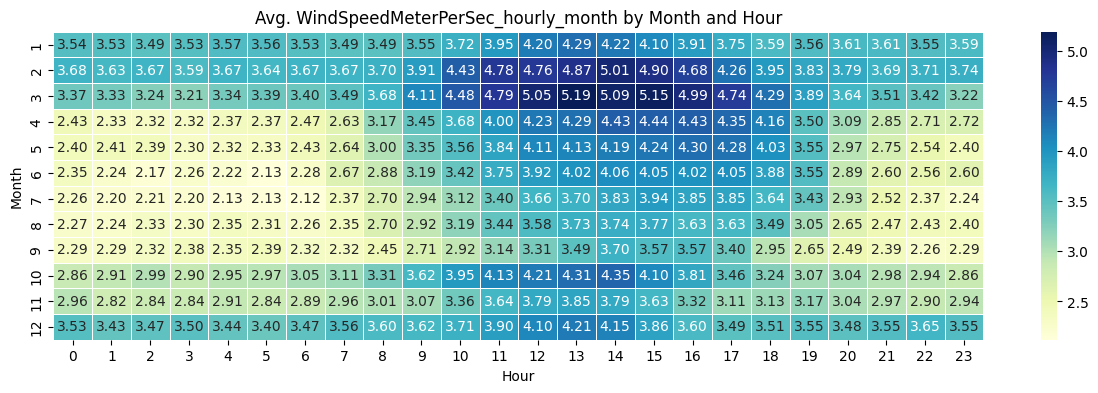

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap
plt.figure(figsize=(15, 4))
sns.heatmap(WindSpeedMeterPerSec_hourly_month, cmap='YlGnBu', linewidths=0.5, annot=True, fmt=".2f")
plt.title('Avg. WindSpeedMeterPerSec_hourly_month by Month and Hour')
plt.xlabel('Hour')
plt.ylabel('Month')
plt.show()

#### The correlation analysis between the number of speed violations and the average wind speed by hour reveals the following correlations:

In [23]:
speed_hourly_month.corrwith(WindSpeedMeterPerSec_hourly_month)

incident_time_modified
0.0    -0.137719
1.0     0.402227
2.0     0.174688
3.0    -0.032599
4.0     0.294974
5.0     0.138999
6.0    -0.007108
7.0    -0.364259
8.0     0.128672
9.0    -0.027275
10.0   -0.132974
11.0   -0.122721
12.0   -0.038911
13.0    0.039360
14.0   -0.041477
15.0   -0.323876
16.0   -0.583349
17.0   -0.335201
18.0   -0.474727
19.0   -0.333447
20.0   -0.098602
21.0   -0.028388
22.0   -0.039274
23.0   -0.096260
dtype: float64

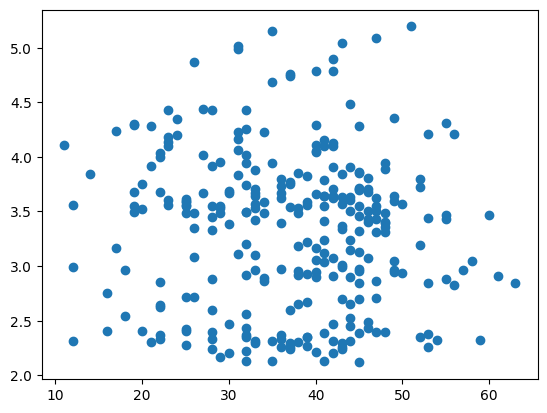

In [24]:
plt.scatter(speed_hourly_month, WindSpeedMeterPerSec_hourly_month)

## Scatterplots: All at Once
**`'WindSpeedMeterPerSec'`**, **`'PrecipitationHeightMillimeter'`**, **`'AirTempCelsius'`**, **`'RelHumidityPercent'`** by hour for each month  vs. **`Speed`** by hour for each month.

Data Preparation and Visualization

1. Calculate the average values for weather parameters (WindSpeedMeterPerSec, PrecipitationHeightMillimeter, AirTempCelsius, RelHumidityPercent) grouped by month and hour
2. Create a pivot table to organize the data by month and hour for each parameter
3. Remove rows with null values to ensure consistent data for analysis
4. Retrieve the corresponding speed violation data for the months and hours in the weather dataset
5. Create a scatter plot for each weather parameter against the number of speed violations
6. Add a correlation line to visualize the correlation between the two variables
7. Calculate the correlation coefficient to quantify the strength and direction of the relationship
8. Display the correlation coefficient on the plot for easy interpretation

Execute the code to generate the scatter plots and correlation analysis

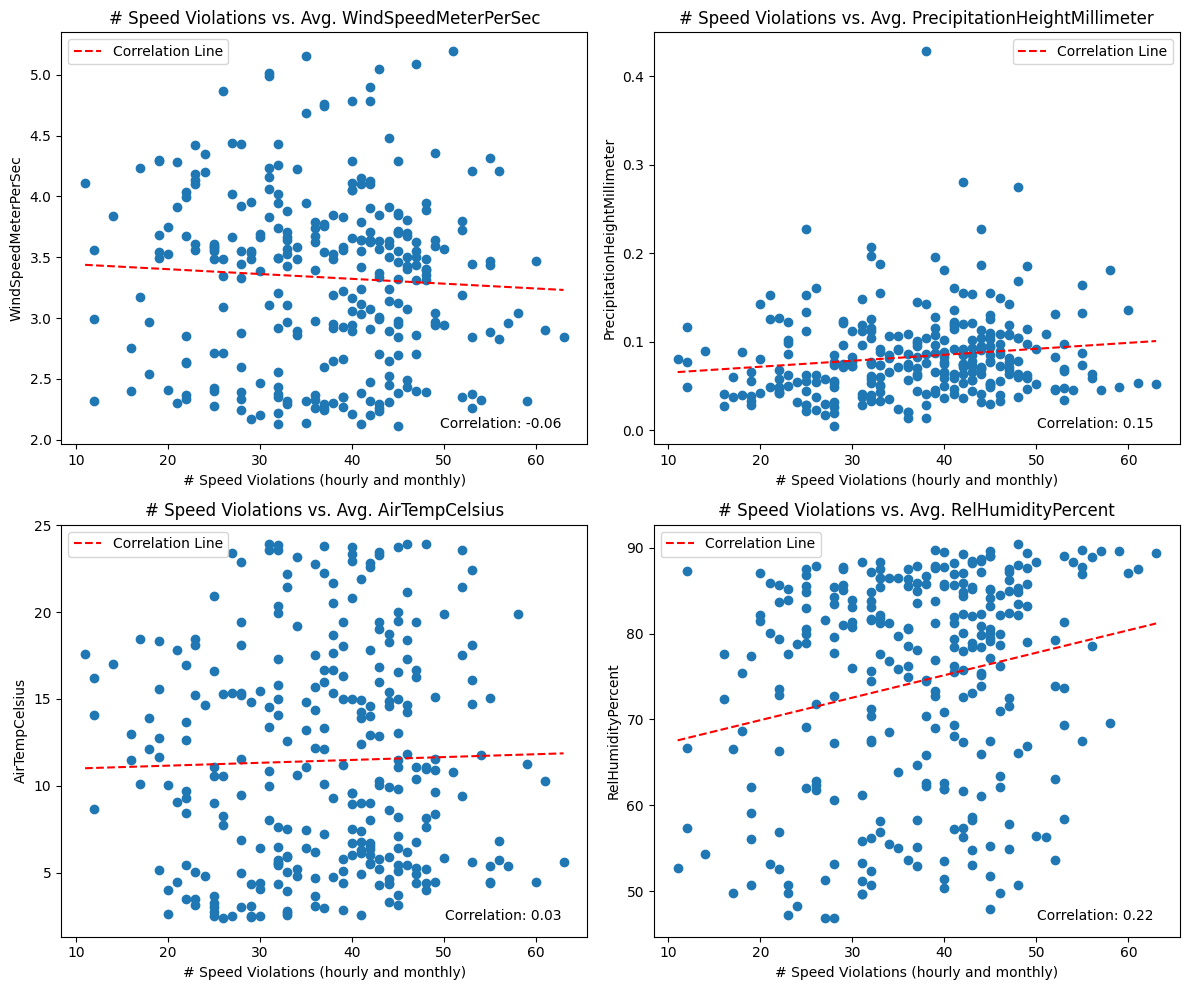

In [25]:
import numpy as np
import matplotlib.pyplot as plt

columns = ['WindSpeedMeterPerSec', 'PrecipitationHeightMillimeter', 'AirTempCelsius', 'RelHumidityPercent']
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, column in enumerate(columns):
    # Calculate average and pivot data
    column_avg = weather_data_filtered_copy.groupby(['month', weather_data_filtered_copy['date_time'].dt.hour])[column].mean().reset_index()
    column_hourly_month = column_avg.pivot(index='month', columns='date_time', values=column)
    
    # Remove rows with null values
    column_hourly_month.dropna(inplace=True)
    
    # Ensure same size for x and y
    speed_hourly_month_filtered = speed_hourly_month.loc[column_hourly_month.index]
    
    # Scatter plot
    ax = axs[i // 2, i % 2]
    ax.scatter(speed_hourly_month_filtered.values.flatten(), column_hourly_month.values.flatten())
    ax.set_xlabel('# Speed Violations (hourly and monthly)')
    ax.set_ylabel(column)
    ax.set_title(f'# Speed Violations vs. Avg. {column}')
    
    # Calculate correlation coefficient
    correlation = np.corrcoef(speed_hourly_month_filtered.values.flatten(), column_hourly_month.values.flatten())[0, 1]
    
    # Add correlation line
    ax.plot(np.unique(speed_hourly_month_filtered.values.flatten()), np.poly1d(np.polyfit(speed_hourly_month_filtered.values.flatten(), column_hourly_month.values.flatten(), 1))(np.unique(speed_hourly_month_filtered.values.flatten())), color='red', linestyle='--', label='Correlation Line')
    
    # Add correlation coefficient to the plot
    ax.text(0.95, 0.05, f'Correlation: {correlation:.2f}', ha='right', va='center', transform=ax.transAxes)
    
    # Display legend
    ax.legend()

plt.tight_layout()
plt.show()

Simple Observations:
- The scatter plots visualize the relationship between weather parameters and the number of speed violations
- The correlation coefficient indicates the strength and direction of the correlation
- The low correlation values suggest that weather factors alone may not have a substantial impact on speed violations
- However, it's important to note that correlation does not imply causation

___
# Conclusions
___

### Insights:

1. **Number of Speed Violations vs. Avg. WindSpeedMeterPerSec (Correlation: -0.06):**
- The correlation value of -0.06 suggests a very weak negative relationship between the number of speed violations and the average wind speed
- It indicates that there is no significant association between wind speed and speed violations in the given data

2. **Number of Speed Violations vs. Avg. PrecipitationHeightMillimeter (Correlation: 0.15):**
- The correlation value of 0.15 suggests a weak positive relationship between the number of speed violations and the average precipitation height
- It indicates that there might be a slight tendency for more speed violations to occur when there is higher average precipitation, although the relationship is not strong

3. **Number of Speed Violations vs. Avg. AirTempCelsius (Correlation: 0.03):**
- The correlation value of 0.03 indicates a very weak positive relationship between the number of speed violations and the average air temperature
- It suggests that there is no significant association between air temperature and speed violations in the given data

4. **Number of Speed Violations vs. Avg. RelHumidityPercent (Correlation: 0.22):**
- The correlation value of 0.22 suggests a weak positive relationship between the number of speed violations and the average relative humidity
- It indicates that there might be a slight tendency for more speed violations to occur when there is higher average relative humidity, although the relationship is not strong

___
### Results:
Overall, it's important to note that the correlation values in all cases are quite low, indicating weak associations between the number of speed violations and the average weather parameters. These results suggest that while there may be some minimal influence of weather conditions on speed violations, other factors are likely to have a more significant impact. Further analysis and consideration of additional variables are needed to gain a more comprehensive understanding of the relationship between weather and speed-related incidents.
___

### Recommendations:

1. **Enhance driver awareness:** Emphasize the importance of adhering to speed limits and safe driving practices regardless of weather conditions. Encourage drivers to exercise caution and adjust their speed based on road and traffic conditions

2. **Weather-based reminders:** During periods of adverse weather, such as high precipitation or high humidity, provide weather-specific reminders to drivers to be extra vigilant and cautious while driving. Emphasize the need to maintain safe speeds and adapt driving behavior to the prevailing weather conditions

3. **Continuous driver education:** Invest in ongoing driver education and training programs that focus on safe driving techniques, hazard perception, and defensive driving skills. These programs can help drivers better understand the potential risks associated with various weather conditions and develop strategies to mitigate them

4. **Monitoring and enforcement:** Implement and maintain consistent monitoring and enforcement of speed limits, regardless of weather conditions. Regular enforcement efforts can contribute to deterrence and reinforce the importance of complying with speed limits at all times

5. **Public awareness campaigns:** Launch public awareness campaigns that highlight the importance of responsible driving and the potential impact of weather conditions on road safety. Promote a culture of safe driving that includes respecting speed limits and adjusting driving behavior in response to weather changes

`Remember, while the influence of weather on speed violations may be small, it is still essential to prioritize road safety and continuously promote responsible driving practices`

___
___
___